In [23]:
from  ContextGenerator import key_context as context
import os
dir = os.getcwd()
if dir.split("/")[-3] == "codebase":
    os.chdir("../../")

In [24]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tenseal as ts
import time


In [25]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out
    


In [26]:
# importing module
import logging


# Create and configure logger
logging.basicConfig(
    filename="encrypted_evaluation.log", format="%(asctime)s %(message)s", filemode="a"
)

Due to the nature of encrypted data we can't do conditional analysis on the inputs, we are also limited to the basic mathametical arithmatic, thus this limits the activation functions we can use. For this example I am going to use an approximation to the Sigmoid Activation,  I am going to minimise the number of polynomial arithmetic to minimise Loss of value whilst still maintain some accuracy for the sigmoid value, I will be using this approximation that''l range the sigmoid to [-5, 5]. Which is done similliarly in this research paper. https://eprint.iacr.org/2018/462.pdf

In [27]:
class EncryptedLinReg:
    def __init__(self, torch_lr):
        self.weight = torch_lr.linear.weight.data.tolist()[0]
        self.bias = torch_lr.linear.bias.data.tolist()
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
        
    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLinReg.sigmoid(enc_out)
        return enc_out
    
    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1
        
    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05       # Our sigmoid work in the range of -5, 5 therefore we scale it down by 0.05
        self.bias -= self._delta_b * (1 / self._count)
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
    
    @staticmethod
    def sigmoid(enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        return enc_x.polyval([0.5, 0.197, 0, -0.004])
    
    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()    
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [28]:
context = context

df = pd.read_csv("./LinearRegression/Data/Custom_Salary_Data.csv")


In [29]:
def test_train_split(df):
    training_data = df.sample(frac=0.8, random_state=25)  #
    testing_data = df.drop(training_data.index)
    y_train, x_train = (
        training_data["YearsExperience"].to_numpy(),
        training_data["Salary"].to_numpy(),
    )
    y_test, x_test = (
        testing_data["YearsExperience"].to_numpy(),
        testing_data["Salary"].to_numpy(),
    )
    return x_train, y_train, x_test, y_test

In [30]:
x_train, y_train, x_test, y_test = test_train_split(df)

x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

x_train_tensor = torch.from_numpy(x_train).double().requires_grad_()
y_train_tensor = torch.from_numpy(y_train).double().requires_grad_()

x_test_tensor = torch.from_numpy(x_test).double().requires_grad_()
y_test_tensor = torch.from_numpy(y_test).double().requires_grad_()

t_start = time.time()
enc_x_train = ts.ckks_tensor(context, x_train)
enc_y_train = ts.ckks_tensor(context, y_train)
t_end = time.time()
print(f"Encryption of the training_set took {(t_end - t_start)} seconds")

Encryption of the training_set took 0.9102864265441895 seconds


In [31]:
x_train_tensor = torch.from_numpy(x_train).double().requires_grad_()
y_train_tensor = torch.from_numpy(y_train).double().requires_grad_()

x_test_tensor = torch.from_numpy(x_test).double().requires_grad_()
y_test_tensor = torch.from_numpy(y_test).double().requires_grad_()

65476.19539617172
Distribution on plain data:


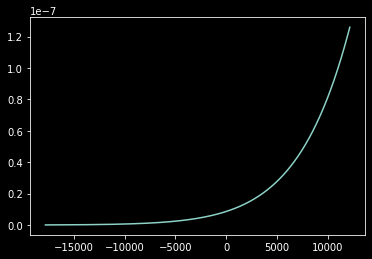

In [32]:


normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-17807, rmax=12193):
    x = np.arange(rmin, rmax, 0.1)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)
    
# plain distribution
lin_reg_model =  LinearRegressionModel(1, 1)
lin_reg_model = lin_reg_model.double()
data = lin_reg_model(x_train_tensor)
mean, var = map(float, [data.mean(), data.std() ** 2])
print(mean)
plot_normal_dist(mean, var)
print("Distribution on plain data:")
plt.show()

In [ ]:
# encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()
    

eelr = EncryptedLinReg(lin_reg_model)
eelr.encrypt(enc_x_train)
encrypted_out_distribution(eelr, enc_x_train)

In [33]:
accuracy = eelr.plain_accuracy(x_test, y_test)
print(f"Accuracy at epoch #0 is {accuracy}")

EPOCHS = 100000

times = []
for epoch in range(EPOCHS):
    eelr.encrypt(enc_x_train)
    
    # if you want to keep an eye on the distribution to make sure
    # the function approxiamation is still working fine
    # WARNING: this operation is time consuming
    # encrypted_out_distribution(eelr, enc_x_train)
    
    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)
    
    eelr.decrypt()
    accuracy = eelr.plain_accuracy(x_test, y_test)
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")


print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
print(f"Final accuracy is {accuracy}")

diff_accuracy = plain_accuracy - accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy when training on encrypted data! The noise was on our side...")

NameError: name 'eelr' is not defined